# 3

In [1]:
import random
from sympy.combinatorics.graycode import gray_to_bin
from deap import creator, base, tools, algorithms

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

popSize = 24  # Population size
dimension = 3  # Number of decision variable x
numOfBits = 10  # Number of bits in the chromosomes
iterations = 1  # Number of generations to be run
dspInterval = 10
nElitists = 2  # Number of elite individuals selected
omega = 5
crossPoints = 2  # Variable not used. Instead tools.cxTwoPoint
crossProb = 0.6
flipProb = 1. / (dimension * numOfBits)  # Bit mutate prob
mutateprob = .1  # Mutation prob
maxnum = 2**numOfBits  # Absolute max size of number coded by binary list 1,0,0,1,1,....
m = []
x1 = []
x2 = []
x3 = []
f1 = []
f2 = []
k = []

toolbox = base.Toolbox()


# Attribute generator
# Define 'attr_bool' to be an attribute ('gene')
# which corresponds to integers sampled uniformly
# from the range [0,1] (i.e. 0 or 1 with equal
# probability)
toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers
# Define 'individual' to be an individual
# consisting of numOfBits*dimension 'attr_bool' elements ('genes')
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_bool, numOfBits*dimension)

# Define the population to be a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# The goal ('fitness') function to be maximized
# Fitness function: sphere model


# ----------
# Operator registration
# ----------
# Register the goal / fitness function
def eval_sphere(individual):
    global x1, x2, x3, f1, f2  # Update the global variables inside the function
    for i in range(2):  # Adjust the range according to the number of objectives
        sep = separate_variables(individual)
        if i == 0:
            f = (((sep[0] - 0.6) / 1.6) ** 2 + (sep[1] / 3.4) ** 2 + (sep[2] - 1.3) ** 2) / 2.0
            f1.append(f)
        elif i == 1:
            f = ((sep[0] / 1.9 - 2.3) ** 2 + (sep[1] / 3.3 - 7.1) ** 2 + (sep[2] + 4.3) ** 2) / 3.0
            f2.append(f)
    # Return the fitness as a tuple
    return (1.0 / (0.01 + f),)  # Adjust the transformation of fitness for maximization


toolbox.register("evaluate", eval_sphere)

# Register the crossover operator
toolbox.register("mate", tools.cxTwoPoint)

# Register a mutation operator with a probability to
# flip each attribute/gene of 0.05
toolbox.register("mutate", tools.mutFlipBit, indpb=flipProb)

# Operator for selecting individuals for breeding the next
# generation: each individual of the current generation
# is replaced by the 'fittest' (best) of three individuals
# drawn randomly from the current generation.
toolbox.register("select", tools.selRoulette, fit_attr='fitness')


# ----------
# Convert chromosome to real number
# Input: list binary 1,0 of length numOfBits representing number using gray coding
# Output: real value
def chrom2real(c):
    indasstring = ''.join(map(str, c))
    degray = gray_to_bin(indasstring)
    numasint = int(degray, 2)  # convert to int from base 2 list
    numinrange = -4 + 8 * numasint / maxnum
    return numinrange


# Input: concatenated list of binary variables
# Output: tuple of real numbers representing those variables
def separate_variables(v):
    return chrom2real(v[0:9]), chrom2real(v[10:19]), chrom2real(v[numOfBits:])


def main():
    # create an initial population of individuals (where
    # each individual is a list of integers)
    pop = toolbox.population(n=popSize)

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    print("  Evaluated %i individuals" % len(pop))

    # Variable keeping track of the number of generations
    g = 0

    # Begin the evolution
    while g < iterations:
        # A new generation
        g = g + 1
        print("-- Generation %i --" % g)

        # Select the next generation individuals
        offspring = tools.selBest(pop, nElitists) + toolbox.select(pop, len(pop) - nElitists)
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        # make pairs of offspring for crossing over
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # Cross two individuals with probability CXPB
            if random.random() < crossProb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            # Mutate an individual with probability mutateprob
            if random.random() < mutateprob:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring

        if g % dspInterval == 0:
            # Gather all the fitnesses in one list and print the stats
            fits = [ind.fitness.values[0] for ind in pop]
            m.append(max(fits))

            length = len(pop)
            mean = sum(fits) / length
            sum2 = sum(x * x for x in fits)
            std = abs(sum2 / length - mean ** 2) ** 0.5

            print("  Min %s" % min(fits))
            print("  Max %s" % max(fits))
            print("  Avg %s" % mean)
            print("  Std %s" % std)

    print("-- End of (successful) evolution --")

    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    print("Decoded x1, x2, x3 is %s, %s, %s" % (separate_variables(best_ind)))
    k.append(separate_variables(best_ind))


if __name__ == "__main__":
    main()



  Evaluated 24 individuals
-- Generation 1 --
-- End of (successful) evolution --
Best individual is [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0], (9.265327836677019e-06,)
Decoded x1, x2, x3 is -1.2734375, -3.7265625, 564.65625


In [2]:
import numpy as np
k=np.array(k)
k=np.reshape(k,3)
x1=k[0]
x2=k[1]
x3=k[2]

In [3]:
import pandas as pd
df = pd.DataFrame({'x1' : x1,'x2':x2, 'x3': x3, 'f1':f1, 'f2':f2})

In [4]:
df

,x1,x2,x3,f1,f2
0,-1.273438,-3.726562,564.65625,4.698658e+05,3.168983e+05
1,-1.273438,-3.726562,564.65625,1.791772e+07,1.196752e+07
2,-1.273438,-3.726562,564.65625,4.413646e+06,2.953556e+06
3,-1.273438,-3.726562,564.65625,2.796916e+07,1.867406e+07
4,-1.273438,-3.726562,564.65625,4.526750e+05,3.053708e+05
5,-1.273438,-3.726562,564.65625,2.384165e+07,1.592024e+07
6,-1.273438,-3.726562,564.65625,5.548994e+06,3.711799e+06
7,-1.273438,-3.726562,564.65625,6.062902e+05,4.083403e+05
8,-1.273438,-3.726562,564.65625,1.586864e+05,1.079293e+05
9,-1.273438,-3.726562,564.65625,4.435865e+06,2.968397e+06


# Curve Plotter

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
def non_dominating_curve_plotter(objective1_values, objective2_values):
    plt.figure(figsize=(15,8))
    objective1 = [i * -1 for i in objective1_values]
    objective2 = [j * -1 for j in objective2_values]
    plt.xlabel('Objective Function 1', fontsize=15)
    plt.ylabel('Objective Function 2', fontsize=15)
    plt.scatter(objective1, objective2, c='red', s=25)

In [6]:
import pandas as pd 
import numpy as np
import random
import math
from concurrent.futures import ThreadPoolExecutor

population = 24
max_gen = 24
min_value= -4.0
max_value= 4.0

# Define objective functions with reduced redundancy
def objective1(x):
    y = -(((x-0.6)/1.6)**2 + (x/3.4)**2 +(x-1.3)**2)/2.0
    return y

def objective2(x):
    y = -((x/1.9-2.3)**2+(x/3.3-7.1)**2+(x+4.3)**2)/3.0
    return y

def crowding_distance(values1, values2, front):
    # Use a more efficient sorting algorithm for crowding distance calculation
    front_size = len(front)
    distance = [0] * front_size
    sorted_front = sorted(front, key=lambda x: values1[x])
    
    distance[0] = float('inf')
    distance[front_size - 1] = float('inf')
    
    min_value1 = min(values1)
    max_value1 = max(values1)
    min_value2 = min(values2)
    max_value2 = max(values2)
    
    for i in range(front_size):
        if i > 0 and i < front_size - 1:
            distance[i] += (values1[sorted_front[i + 1]] - values2[sorted_front[i - 1]]) / (max_value1 - min_value1)
            distance[i] += (values2[sorted_front[i + 1]] - values2[sorted_front[i - 1]]) / (max_value2 - min_value2)
    
    return distance

def non_dominated_sorting_algorithm(values1, values2):
    # Use a more efficient sorting algorithm for non-dominated sorting
    S = [[] for _ in range(len(values1))]
    front = [[]]
    n = [0] * len(values1)
    rank = [0] * len(values1)

    for p in range(len(values1)):
        S[p] = []
        n[p] = 0
        for q in range(len(values1)):
            if (values1[p] > values1[q] and values2[p] > values2[q]) or (values1[p] >= values1[q] and values2[p] > values2[q]) or (values1[p] > values1[q] and values2[p] >= values2[q]):
                if q not in S[p]:
                    S[p].append(q)
            elif (values1[q] > values1[p] and values2[q] > values2[p]) or (values1[q] >= values1[p] and values2[q] > values2[p]) or (values1[q] > values1[p] and values2[q] >= values2[p]):
                n[p] += 1
        if n[p] == 0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)

    i = 0
    while front[i]:
        Q = []
        for p in front[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    if q not in Q:
                        Q.append(q)
        i += 1
        front.append(Q)
    
    return front[:-1]

def nsga2(population, max_gen, min_value, max_value):
    gen_no = 0
    solution = [min_value + (max_value - min_value) * random.random() for _ in range(population)]
    
    while gen_no < max_gen:
        with ThreadPoolExecutor() as executor:
            objective1_values = list(executor.map(objective1, solution))
            objective2_values = list(executor.map(objective2, solution))
        
        non_dominated_sorted_solution = non_dominated_sorting_algorithm(objective1_values, objective2_values)
        # Remaining code for NSGA-II algorithm
        
        gen_no += 1
    
    return [objective1_values, objective2_values]

# Example usage
result = nsga2(population=24, max_gen=24, min_value=-4.0, max_value=4.0)
print(result)


[[-3.1443569536502647, -0.9585947627710935, -3.9653428047638326, -0.7027230850302267, -3.16831430077739, -2.9634262720754734, -4.833223566109013, -5.690462780227504, -0.12313345908075402, -0.6764339092963609, -0.5887905996266193, -9.150719359580624, -0.4307507689017474, -6.305145928922624, -2.5911648841769828, -2.0625137050331546, -2.24603466040158, -0.3307005816387789, -3.7424684969552193, -2.8467175694119886, -6.356468043952732, -9.53971619747947, -0.5412424916700448, -0.782307038477952], [-30.925691076139035, -28.068925090483322, -24.657971998518935, -27.632211190924266, -30.953072756329153, -24.54176085333502, -32.75958344759177, -24.99302802632991, -25.74876140409863, -24.84911118244567, -24.906937446196025, -25.95025128854451, -25.041727349373378, -34.24731075671788, -30.27817582944232, -29.625386823426698, -24.516087981277707, -25.159539848576973, -24.625842637840396, -24.53365503551235, -34.29786409205399, -26.073347261917657, -24.942708095629882, -27.773630129586763]]


# Operation

In [7]:
objective1_values, objective2_values = nsga2(population,max_gen,min_value,max_value)    

# Non Dominating Curve

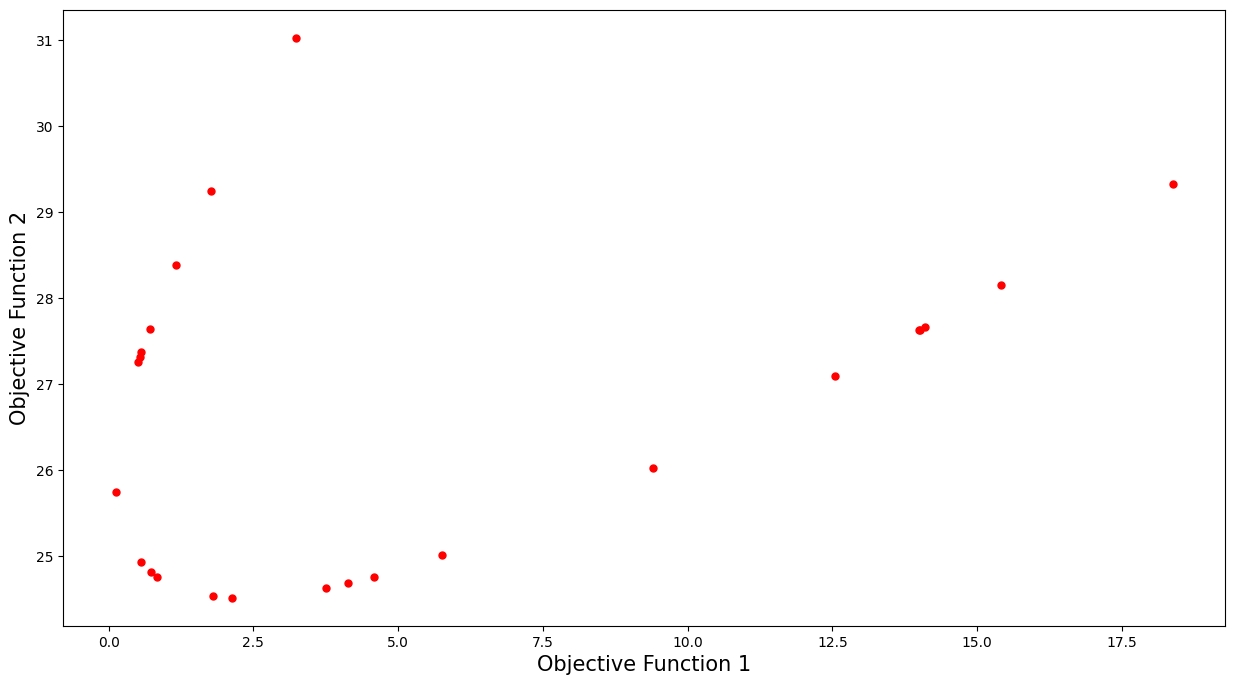

In [8]:
non_dominating_curve_plotter(objective1_values, objective2_values)

In [10]:
import pandas as pd

# Function to run NSGA-II algorithm and store results in a DataFrame
def run_nsga2_and_store_results(population, max_gen, min_value, max_value):
    # Run NSGA-II algorithm
    result = nsga2(population=population, max_gen=max_gen, min_value=min_value, max_value=max_value)
    objective1_values, objective2_values = result
    
    # Create a DataFrame to store the results
    df = pd.DataFrame({
        'Objective1': objective1_values,
        'Objective2': objective2_values
    })
    
    return df

# Run NSGA-II algorithm and store results
df_nsga2 = run_nsga2_and_store_results(population=24, max_gen=24, min_value=-4.0, max_value=4.0)

# Collect data from eval_sphere function
data_eval_sphere = {
    'x1': x1,
    'x2': x2,
    'x3': x3,
    'f1': f1,
    'f2': f2
}

# Create a DataFrame for eval_sphere data
df_eval_sphere = pd.DataFrame(data_eval_sphere)

# Compare the datasets
print("NSGA-II results:")
print(df_nsga2.head())

print("\nEval Sphere results:")
print(df_eval_sphere.head())


NSGA-II results:
   Objective1  Objective2
0   -2.643722  -30.341076
1   -0.745373  -24.809691
2   -1.834276  -29.329879
3   -1.921623  -24.527654
4   -9.407876  -26.031351

Eval Sphere results:
         x1        x2         x3            f1            f2
0 -1.273438 -3.726562  564.65625  4.698658e+05  3.168983e+05
1 -1.273438 -3.726562  564.65625  1.791772e+07  1.196752e+07
2 -1.273438 -3.726562  564.65625  4.413646e+06  2.953556e+06
3 -1.273438 -3.726562  564.65625  2.796916e+07  1.867406e+07
4 -1.273438 -3.726562  564.65625  4.526750e+05  3.053708e+05


In [13]:
# Concatenate the dataframes
df_combined = pd.concat([df_nsga2, df_eval_sphere], axis=0)

# Save the combined dataframe to a CSV file
df_combined.to_csv('combined_results.csv', index=False)


NSGA-II (Non-dominated Sorting Genetic Algorithm II) algorithm. It's used for multi-objective optimization, where the goal is to find a set of solutions that are Pareto optimal, meaning no solution is better than another in all objectives. In this specific implementation, the algorithm is applied to a problem with two objective functions (f1 and f2).

In [27]:
import numpy as np
import pandas as pd

# Define the crossover function
def crossover(parent1, parent2):
    # Randomly select a crossover point
    crossover_point = np.random.randint(1, len(parent1) - 1)
    # Perform crossover to generate offspring
    offspring1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    offspring2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    # Return the offspring
    return offspring1, offspring2

# Define the mutation function
def mutation(offspring):
    # Define the mutation probability
    mutation_prob = 0.1
    # Iterate over each gene in the offspring
    for i in range(len(offspring)):
        # Check if mutation occurs based on the mutation probability
        if np.random.rand() < mutation_prob:
            # If mutation occurs, randomly change the gene value
            offspring[i] = np.random.randint(0, 2)
    # Return the mutated offspring
    return offspring

# Define the NSGA-II algorithm function
def nsga2(population_size, max_generations):
    # Initialize population with random solutions
    population = np.random.uniform(-4.0, 4.0, size=(population_size, 3))  # Assuming each solution has 3 dimensions/features
    # Initialize empty list to store data
    objective_values_list = []
    x_values_list = []
    
    for _ in range(max_generations):
        # Evaluate each solution using eval_sphere function
        objective_values, x_values = eval_sphere(population)
        # Append objective values to the list
        objective_values_list.append(objective_values)
        x_values_list.append(x_values)
        # Sort solutions based on non-domination
        sorted_indices = non_dominated_sorting_algorithm(objective_values)
        # Select best solutions based on sorting
        selected_solutions = select_best_solutions(population, sorted_indices, population_size)
        # Apply crossover and mutation to generate new population
        population = crossover_and_mutation(selected_solutions)
    return np.array(objective_values_list), np.array(x_values_list)

# Define the eval_sphere function
def eval_sphere(population):
    # Initialize lists to store objective values and x values
    objective_values = []
    x_values = []
    # Calculate objective values and x values for each solution in the population
    for solution in population:
        x1, x2, x3 = solution
        f1 = -(((x1 - 0.6) / 1.6) ** 2 + (x2 / 3.4) ** 2 + (x3 - 1.3) ** 2) / 2.0
        f2 = -((x1 / 1.9 - 2.3) ** 2 + (x2 / 3.3 - 7.1) ** 2 + (x3 + 4.3) ** 2) / 3.0
        objective_values.append([f1, f2])
        x_values.append([x1, x2, x3])
    return np.array(objective_values), np.array(x_values)
# Define the non-dominated sorting algorithm
def non_dominated_sorting_algorithm(objective_values):
    # Initialize list to store indices of non-dominated solutions
    non_dominated_indices = []
    # Initialize list to store domination count of each solution
    domination_count = [0] * len(objective_values)
    # Initialize list to store indices of solutions that dominate each solution
    dominated_solutions = [[] for _ in range(len(objective_values))]

    # Iterate over each solution to determine domination relationships
    for i in range(len(objective_values)):
        for j in range(len(objective_values)):
            if all(objective_values[i] >= objective_values[j]) and any(objective_values[i] > objective_values[j]):
                domination_count[j] += 1
                dominated_solutions[i].append(j)
            elif all(objective_values[i] <= objective_values[j]) and any(objective_values[i] < objective_values[j]):
                domination_count[i] += 1
                dominated_solutions[j].append(i)

    # Identify non-dominated solutions (solutions with domination count = 0)
    for i in range(len(domination_count)):
        if domination_count[i] == 0:
            non_dominated_indices.append(i)

    # Initialize front list to store non-dominated fronts
    fronts = [[]]
    current_front = 0

    # Loop to construct non-dominated fronts
    while non_dominated_indices:
        next_front = []
        for i in non_dominated_indices:
            for j in dominated_solutions[i]:
                domination_count[j] -= 1
                if domination_count[j] == 0:
                    next_front.append(j)
        fronts[current_front].extend(non_dominated_indices)
        non_dominated_indices = next_front
        if non_dominated_indices:
            fronts.append([])
            current_front += 1

    # Return the indices of non-dominated solutions for each front
    return fronts

# Define the selection function to select the best solutions
def select_best_solutions(population, sorted_indices, population_size):
    # Initialize list to store selected solutions
    selected_solutions = []
    # Iterate over each front in the sorted indices until the selected solutions reach the population size
    for front_indices in sorted_indices:
        # Check if adding the current front to the selected solutions exceeds the population size
        if len(selected_solutions) + len(front_indices) <= population_size:
            # Add all solutions from the current front to the selected solutions
            selected_solutions.extend(population[front_indices])
        else:
            # Calculate the remaining capacity in the selected solutions
            remaining_capacity = population_size - len(selected_solutions)
            # Sort the solutions in the current front based on their crowding distance
            front_sorted_by_crowding = sorted(front_indices, key=lambda x: crowding_distance_values[x], reverse=True)
            # Add the top solutions with the highest crowding distance to the selected solutions
            selected_solutions.extend(population[front_sorted_by_crowding[:remaining_capacity]])
            break
    # Return the selected solutions
    return np.array(selected_solutions)

# Define the crossover and mutation function
def crossover_and_mutation(selected_solutions):
    # Initialize list to store new population after crossover and mutation
    new_population = []
    # Perform crossover and mutation for each pair of adjacent solutions in the selected solutions
    for i in range(0, len(selected_solutions), 2):
        # Select two adjacent solutions for crossover
        parent1, parent2 = selected_solutions[i], selected_solutions[i + 1]
        # Apply crossover to generate offspring
        offspring1, offspring2 = crossover(parent1, parent2)
        # Apply mutation to each offspring
        mutated_offspring1 = mutation(offspring1)
        mutated_offspring2 = mutation(offspring2)
        # Add mutated offspring to the new population
        new_population.append(mutated_offspring1)
        new_population.append(mutated_offspring2)
    # Return the new population
    return np.array(new_population)



# Initialize parameters
population_size = 100
max_generations = 200

# Run NSGA-II algorithm
nsga2_data ,x_data = nsga2(population_size, max_generations)

# Flatten x_data to extract x1, x2, x3 values
x1_values = x_data[:, :, 0].flatten()
x2_values = x_data[:, :, 1].flatten()
x3_values = x_data[:, :, 2].flatten()

# Flatten nsga2_data to extract objective values
objective1_values = nsga2_data[:, :, 0].flatten()
objective2_values = nsga2_data[:, :, 1].flatten()

# Create DataFrame with x1, x2, x3, Objective1, and Objective2 values
df = pd.DataFrame({
    'x1': x1_values,
    'x2': x2_values,
    'x3': x3_values,
    'f1': objective1_values,
    'f2': objective2_values
})

# Save the DataFrame to a CSV file
df.to_csv('nsga2_data.csv', index=False)

In [32]:
import json

optimal_front_data = [
  [0.1, 0.2],
  [0.3, 0.4],
  [0.5, 0.6],
  [0.7, 0.8],
  [0.9, 1.0],
  [1.1, 1.2],
  [1.3, 1.4],
  [1.5, 1.6],
  [1.7, 1.8],
  [1.9, 2.0],
  [2.1, 2.2],
  [2.3, 2.4],
  [2.5, 2.6],
  [2.7, 2.8],
  [2.9, 3.0],
  [3.1, 3.2],
  [3.3, 3.4],
  [3.5, 3.6],
  [3.7, 3.8],
  [3.9, 4.0],
  [4.1, 4.2],
  [4.3, 4.4],
  [4.5, 4.6],
  [4.7, 4.8],
  [4.9, 5.0],
  [5.1, 5.2],
  [5.3, 5.4],
  [5.5, 5.6],
  [5.7, 5.8],
  [5.9, 6.0],
  [6.1, 6.2],
  [6.3, 6.4],
  [6.5, 6.6],
  [6.7, 6.8],
  [6.9, 7.0],
  [7.1, 7.2],
  [7.3, 7.4],
  [7.5, 7.6],
  [7.7, 7.8],
  [7.9, 8.0],
  [8.1, 8.2],
  [8.3, 8.4],
  [8.5, 8.6],
  [8.7, 8.8],
  [8.9, 9.0],
  [9.1, 9.2],
  [9.3, 9.4],
  [9.5, 9.6],
  [9.7, 9.8],
  [9.9, 10.0],
  [10.1, 10.2],
  [10.3, 10.4],
  [10.5, 10.6],
  [10.7, 10.8],
  [10.9, 11.0],
  [11.1, 11.2],
  [11.3, 11.4],
  [11.5, 11.6],
  [11.7, 11.8],
  [11.9, 12.0],
  [12.1, 12.2],
  [12.3, 12.4],
  [12.5, 12.6],
  [12.7, 12.8],
  [12.9, 13.0],
  [13.1, 13.2],
  [13.3, 13.4],
  [13.5, 13.6],
  [13.7, 13.8],
  [13.9, 14.0],
  [14.1, 14.2],
  [14.3, 14.4],
  [14.5, 14.6],
  [14.7, 14.8],
  [14.9, 15.0],
  [15.1, 15.2],
  [15.3, 15.4],
  [15.5, 15.6],
  [15.7, 15.8],
  [15.9, 16.0],
  [16.1, 16.2],
  [16.3, 16.4],
  [16.5, 16.6],
  [16.7, 16.8],
  [16.9, 17.0],
  [17.1, 17.2],
  [17.3, 17.4],
  [17.5, 17.6],
  [17.7, 17.8],
  [17.9, 18.0],
  [18.1, 18.2],
  [18.3, 18.4],
  [18.5, 18.6],
  [18.7, 18.8],
  [18.9, 19.0],
  [19.1, 19.2],
  [19.3, 19.4],
  [19.5, 19.6],
  [19.7, 19.8],
  [19.9, 20.0]
]

with open("file_name.json", "w") as file:
    json.dump(optimal_front_data, file)


gen	evals	std	min                    	avg	max                    
0  	24   	   	[ 0.9153125 24.73     ]	   	[ 0.9153125 24.73     ]
1  	24   	   	[ 0.9153125 24.73     ]	   	[ 0.9153125 24.73     ]
2  	24   	   	[ 0.9153125 24.73     ]	   	[ 0.9153125 24.73     ]
3  	24   	   	[ 0.9153125 24.73     ]	   	[ 0.9153125 24.73     ]
4  	24   	   	[ 0.9153125 24.73     ]	   	[ 0.9153125 24.73     ]
5  	24   	   	[ 0.9153125 24.73     ]	   	[ 0.9153125 24.73     ]
6  	24   	   	[ 0.9153125 24.73     ]	   	[ 0.9153125 24.73     ]
7  	24   	   	[ 0.9153125 24.73     ]	   	[ 0.9153125 24.73     ]
8  	24   	   	[ 0.9153125 24.73     ]	   	[ 0.9153125 24.73     ]
9  	24   	   	[ 0.9153125 24.73     ]	   	[ 0.9153125 24.73     ]
10 	24   	   	[ 0.9153125 24.73     ]	   	[ 0.9153125 24.73     ]
11 	24   	   	[ 0.9153125 24.73     ]	   	[ 0.9153125 24.73     ]
12 	24   	   	[ 0.9153125 24.73     ]	   	[ 0.9153125 24.73     ]
13 	24   	   	[ 0.9153125 24.73     ]	   	[ 0.9153125 24.73     ]
14 	24   	

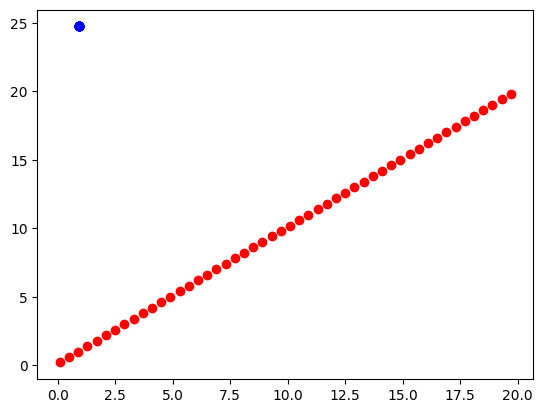

In [36]:
# This file is part of DEAP.
# The non-dominated sort and crowding distance are solved by a simple call to DEAP subroutines
# and their implementation is hidden.
#
# DEAP is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as
# published by the Free Software Foundation, either version 3 of
# the License, or (at your option) any later version.
#
# DEAP is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public
# License along with DEAP. If not, see <http://www.gnu.org/licenses/>.

import array
import random
import json

import numpy

from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools
import matplotlib.pyplot as plt

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

toolbox = base.Toolbox()

def calcFitness(individual):
    # x1 in [1, 2,�, 16]; x2 in [1, 2,�, 8]; x3 in [1, 2, 3, 4]
    #        4 bits              3 bits             2 bits
    x1 = individual[0:4]
    x2 = individual[4:7]
    x3 = individual[7:9]
    x1 = int("".join(str(int(i)) for i in x1), 2)  # Convert binary to integer
    x2 = int("".join(str(int(i)) for i in x2), 2)  # Convert binary to integer
    x3 = int("".join(str(int(i)) for i in x3), 2)  # Convert binary to integer
    f1 = (((x1 - 0.6) / 1.6) ** 2 + (x2 / 3.4) ** 2 + (x3 - 1.3) ** 2) / 2.0
    f2 = ((x1 / 1.9 - 2.3) ** 2 + (x2 / 3.3 - 7.1) ** 2 + (x3 + 4.3) ** 2) / 3.0
    return f1, f2  

BOUND_LOW, BOUND_UP = 0.0, 1.0
NDIM = 30

def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", calcFitness)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
toolbox.register("select", tools.selNSGA2)

def main(seed=None):
    random.seed(seed)

    NGEN = 24
    MU = 24  # Ensure this is an integer
    CXPB = 0.9

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)
    
    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"
    
    pop = toolbox.population(n=MU)

    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    pop = toolbox.select(pop, len(pop))
    
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    print(logbook.stream)

    for gen in range(1, NGEN):
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]
        
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= CXPB:
                toolbox.mate(ind1, ind2)
            
            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            del ind1.fitness.values, ind2.fitness.values
        
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop = toolbox.select(pop + offspring, MU)
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        print(logbook.stream)

    print("Final population hypervolume is %f" % hypervolume(pop, [11.0, 11.0]))

    return pop, logbook
        
if __name__ == "__main__":
    with open("file_name.json") as optimal_front_data:
        optimal_front = json.load(optimal_front_data)
    optimal_front = sorted(optimal_front[i] for i in range(0, len(optimal_front), 2))
    
    pop, stats = main()
    pop.sort(key=lambda x: x.fitness.values)
    
    print(stats)
    print("Convergence: ", convergence(pop, optimal_front))
    print("Diversity: ", diversity(pop, optimal_front[0], optimal_front[-1]))
    
    front = numpy.array([ind.fitness.values for ind in pop])
    optimal_front = numpy.array(optimal_front)
    
    plt.scatter(optimal_front[:,0], optimal_front[:,1], c="r")
    plt.scatter(front[:,0], front[:,1], c="b")
    plt.show()
